In [23]:
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

# Getting Started with the Two-Level Atom

The first model we'll consider is a medium of two-level atoms, coupled by a weak pulse.

```
____ |1>
 |
 | Ω
 |
____ |0>
```

We'll need to define a field, and the two-level atom for the field to address.

## Defining the Field and Atom

In [24]:
from maxwellbloch import field, ob_atom

First we'll define the field. The quantity we care about is the input Rabi frequency as a function of time, $\Omega(t)$. Let's say our input pulse has a max $\Omega_0 = 2\pi \cdot 0.001 \mathrm{~ MHz}$, and is a Gaussian with a full-width at half-maximum (FWHM) of $1 \mathrm{~ \mu s}$.

In [25]:
the_field = field.Field(
    coupled_levels=[[0, 1]],
    rabi_freq=1.0e-3,               # [2π MHz]
    rabi_freq_t_func='gaussian',
    rabi_freq_t_args={
        'ampl': 1.0,                
        'centre': 0.0,              # [μs]
        'fwhm': 1.0},               # [μs]
    )

The first property `coupled_levels` is a list of pairs to be coupled by the field. In this case we only have two levels, indexed `0` (the ground state) and `1` (the excited state). The properties `rabi_freq`, `rabi_freq_t_func` and `rabi_freq_t_args` together define the field profile entering the medium. What does the profile look like in this case?

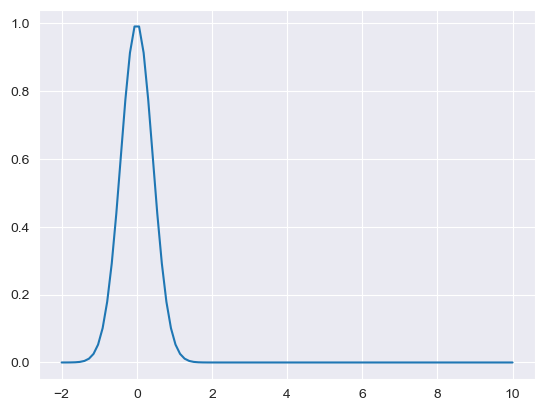

In [26]:
from maxwellbloch import t_funcs

tlist = np.linspace(-2, 10, 100)
plt.plot(tlist, t_funcs.gaussian(1)(tlist, args={ 'ampl_1': 1.0, 'centre_1': 0.0, 'fwhm_1': 1.0}));

It's a Gaussian-shaped pulse, centred at $t=0$. Many more pre-defined profiles are defined in the `t_funcs` module, see [REF t_funcs doc] for details. 

So that's the field. Now we need to define an atom to address. Here we just need to state that `num_states=2`. The atom also takes a list of fields, in this case we've only got one, `the_field`, so we'll add that.

In [27]:
the_atom = ob_atom.OBAtom(
    num_states=2,
    )
the_atom.fields.append(the_field)

## Solving the Maxwell-Bloch Equations

Now we have everything required to solve the problem. We just need to define the space $z$ and time $t$ dimesions we want to solve the problem over. Let's say that our medium is $1 \mathrm{~ cm}$ long and has constant number density, for example a vapour cell.

In [6]:
from maxwellbloch import mb_solve

In [7]:
mbs = mb_solve.MBSolve(
    t_min=-2.0,                     # [μs]
    t_max=10.0,                     # [μs]
    t_steps=100, 
    z_min=-0.5,                     # [cm]
    z_max=1.5,                      # [cm]
    z_steps=10,
    interaction_strengths=[0.1]     # [2π MHz /cm] 
)
mbs.atom = the_atom

Here we've set `z_min=-0.5` and `z_max=1.5` so that we can see how the pulse travels before and after it is in the medium, i.e. as it travels in vacuum.

### Interaction Strength

The interaction strength ($Ng$) for each field describes the strength of the coupling of the field to the medium. You can think of it as the amount of absorption per unit length of medium, so in this system it has units of $\mathrm{2\pi~MHz~/cm}$.

Now we can solve the system.

In [8]:
Omegas_zt, states_zt = mbs.mbsolve()

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.34s. Est. time left: 00:00:00:00
50.0%. Run time:   0.45s. Est. time left: 00:00:00:00
60.0%. Run time:   0.56s. Est. time left: 00:00:00:00
70.0%. Run time:   0.67s. Est. time left: 00:00:00:00
80.0%. Run time:   0.78s. Est. time left: 00:00:00:00
90.0%. Run time:   0.89s. Est. time left: 00:00:00:00
Total run time:   1.00s


The solver indicates progress as it goes, in 10% increments by default.

## Plotting and Analysing Results

The solver returns two objects. `Omegas_zt` contains the complex value of each field, at each $z$-point and each $t$-point. In this case we have only one field, $50+1$ $z$-points (for 50 `z_steps`) and $100+1$ $t$-points (for 100 `t_steps`). 

In [9]:
Omegas_zt.shape

(1, 11, 101)

`states_zt` contains the density matrix representation of the states of the atoms at each $z$-point and each $t$-point. The density matrix $\rho$ is of size $n \times n$ where $n$ is the number of states in the atom, in this case $n=2$.

In [10]:
states_zt.shape

(11, 101, 2, 2)

Both the Rabi frequency $\Omega$ and the density matrix $\rho$ are complex-valued, so the elements of both `Omegas_zt` and `states_zt`
are of `np.complex` datatype.

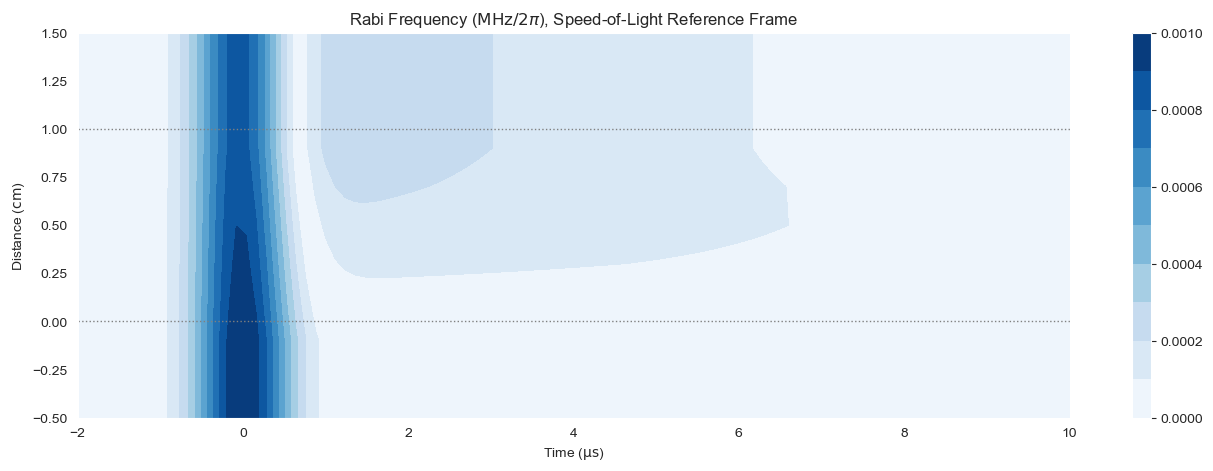

In [11]:
fig, ax = plt.subplots(figsize=(16, 5))
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.abs(mbs.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\mathrm{MHz} / 2\pi $), Speed-of-Light Reference Frame')
ax.set_xlabel('Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Distance ($\mathrm{cm}$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

The plot above shows the absolute value of `Omegas_zt[0]`, the simulated result of propagation of the weak pulse through the two-level medium. Time $t$ is shown on the $x$-axis and the propagation distance $z$ is shown on the $y$-axis such that the field enters at the bottom of the plot. The
horizontal slice at $z = 0$ thus represents the input field pulse. 

This results is presented in the speed-of-light reference frame. That means that a pulse travelling at the speed of light $c$ moves vertically in a plot like the one above. See [REF reference frame] for how we shift into the lab frame.

### Analysis

What happens in this simulation? We can see that the pulse is attenuated by the medium, in that the maximum of the peak leaving the medium at $z=1~\mathrm{cm}$ is lower than the maximum peak entering at $z=0~\mathrm{cm}$. 

We also see that the pulse is slightly fast, such that the peak arrives at the back of the medium, $z=1~\mathrm{cm}$, at
a time $t < 0~\mathrm{\mu s}$ in this speed-of-light reference frame. This is typical of propagation through a medium with a normal dispersion profile. [REF spectral analysis]. There's a little bit of ringing after (to the right) of the pulse, seen in the lighter region.

## Defining the System with JSON

We went through defining `Field`, `Atom` and `MBSolve` objects separately so I could introduce these concepts, but in practice it is rare that we will need to interact with these directly. The whole problem can be defined via a JSON file or string. Here is the same system above defined in JSON.

In [12]:
mbs_json = """
{
  "atom": {
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "rabi_freq": 1.0e-3,
        "rabi_freq_t_args": {
          "ampl": 1.0,
          "centre": 0.0,
          "fwhm": 1.0
        },
        "rabi_freq_t_func": "gaussian"
      }
    ],
    "num_states": 2
  },
  "t_min": -2.0,
  "t_max": 10.0,
  "t_steps": 100,
  "z_min": -0.2,
  "z_max": 1.2,
  "z_steps": 10,
  "interaction_strengths": [
    0.1
  ]
}
"""

We can load these using the `from_json(fname)` method for a JSON file or the `from_json_str(json_str)` method for a string like the one above.

In [13]:
mbs = mb_solve.MBSolve().from_json_str(mbs_json)

Then we can solve the problem exactly as we did above.

In [14]:
Omegas_zt, states_zt = mbs.mbsolve()

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.33s. Est. time left: 00:00:00:00
50.0%. Run time:   0.44s. Est. time left: 00:00:00:00
60.0%. Run time:   0.55s. Est. time left: 00:00:00:00
70.0%. Run time:   0.65s. Est. time left: 00:00:00:00
80.0%. Run time:   0.75s. Est. time left: 00:00:00:00
90.0%. Run time:   0.87s. Est. time left: 00:00:00:00
Total run time:   0.97s


From now on we'll nearly always define MaxwellBloch problems like this with JSON. And just to check we get the same result as above, we'll plot the simulated field again.

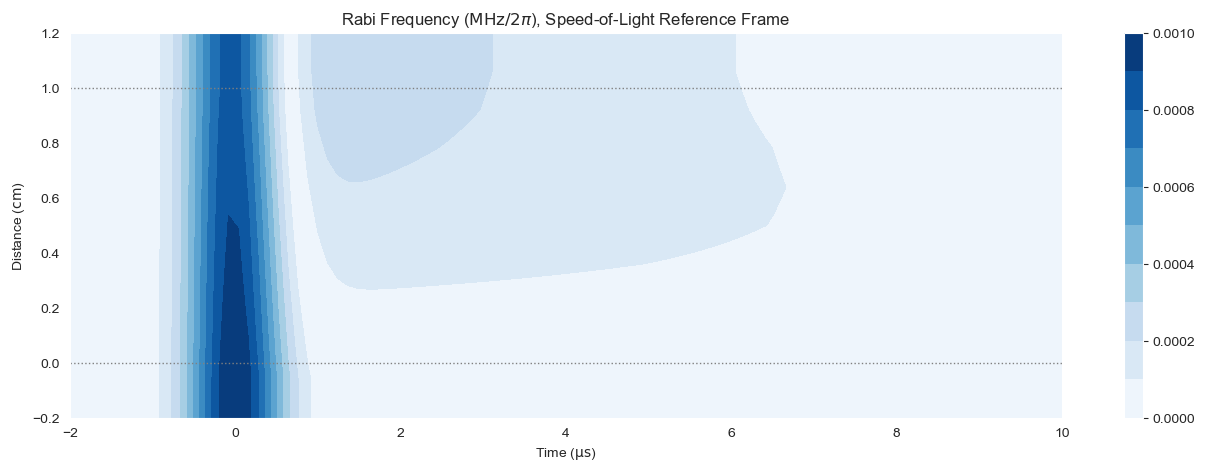

In [15]:
fig, ax = plt.subplots(figsize=(16, 5))
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.abs(mbs.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\mathrm{MHz} / 2\pi $), Speed-of-Light Reference Frame')
ax.set_xlabel('Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Distance ($\mathrm{cm}$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

### Adding More Atoms

What happens if we want to increase the number density $N$ of the medium? We'll define the same problem but increase the `interaction_strength` by a factor of 10.

In [16]:
mbs_json = """
{
  "atom": {
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "rabi_freq": 1.0e-3,
        "rabi_freq_t_args": {
          "ampl": 1.0,
          "centre": 0.0,
          "fwhm": 1.0
        },
        "rabi_freq_t_func": "gaussian"
      }
    ],
    "num_states": 2
  },
  "t_min": -2.0,
  "t_max": 10.0,
  "t_steps": 100,
  "z_min": -0.5,
  "z_max": 1.5,
  "z_steps": 20,
  "interaction_strengths": [
    1.0
  ]
}
"""

mbs = mb_solve.MBSolve().from_json_str(mbs_json)
Omegas_zt, states_zt = mbs.mbsolve()

10.0%. Run time:   0.11s. Est. time left: 00:00:00:00
20.0%. Run time:   0.32s. Est. time left: 00:00:00:01
30.0%. Run time:   0.53s. Est. time left: 00:00:00:01
40.0%. Run time:   0.85s. Est. time left: 00:00:00:01
50.0%. Run time:   1.16s. Est. time left: 00:00:00:01
60.0%. Run time:   1.43s. Est. time left: 00:00:00:00
70.0%. Run time:   1.73s. Est. time left: 00:00:00:00
80.0%. Run time:   2.03s. Est. time left: 00:00:00:00
90.0%. Run time:   2.32s. Est. time left: 00:00:00:00
Total run time:   2.61s


And again we'll plot the absolute value of the Rabi frequency, $| \Omega(z,t) |$, over the medium.

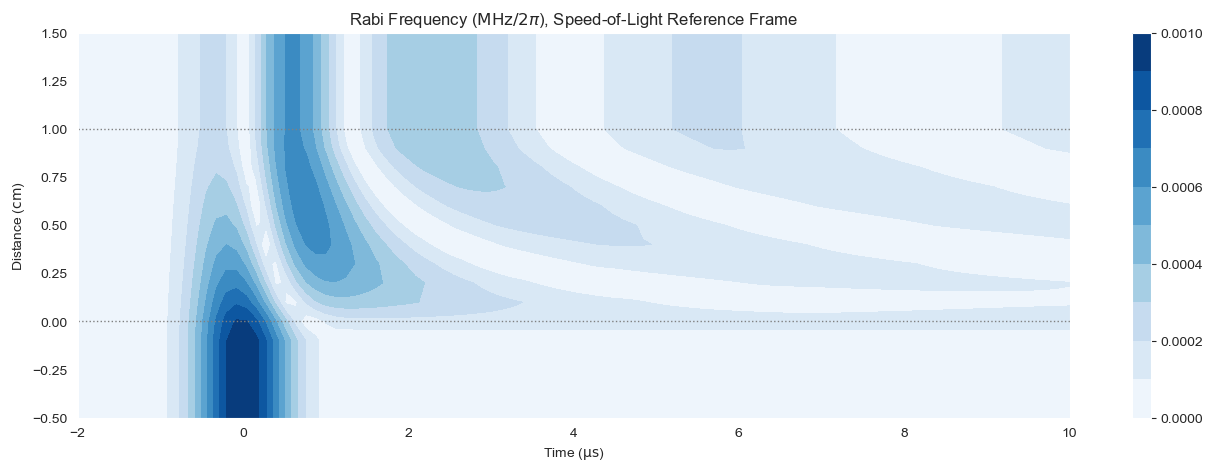

In [17]:
fig, ax = plt.subplots(figsize=(16, 5))
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.abs(mbs.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\mathrm{MHz} / 2\pi $), Speed-of-Light Reference Frame')
ax.set_xlabel('Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Distance ($\mathrm{cm}$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

## Spontaneous Decay
 
To include spontaneous decay in the Lindblad master equation we have to add collapse operators. We add a list of `decays` into the `atom`, each with a list of channels describing the decays (ordered `lower` then `upper`) and a decay rate in the same units as the rabi frequency (in this case $2\pi \mathrm{~ MHz}$). Lets say in our system the decay rate is $2\pi \cdot 1 \mathrm{~ MHz}$.

Otherwise we'll leave the system the same.

In [18]:
mbs_json = """
{
  "atom": {
    "decays": [
      {
        "channels": [[0, 1]],
        "rate": 1.0
      }
    ],
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "rabi_freq": 1.0e-3,
        "rabi_freq_t_args": {
          "ampl": 1.0,
          "centre": 0.0,
          "fwhm": 1.0
        },
        "rabi_freq_t_func": "gaussian"
      }
    ],
    "num_states": 2
  },
  "t_min": -2.0,
  "t_max": 10.0,
  "t_steps": 100,
  "z_min": -0.5,
  "z_max": 1.5,
  "z_steps": 20,
  "interaction_strengths": [
    1.0
  ]
}
"""

mbs = mb_solve.MBSolve().from_json_str(mbs_json)
Omegas_zt, states_zt = mbs.mbsolve()

10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.32s. Est. time left: 00:00:00:01
30.0%. Run time:   0.53s. Est. time left: 00:00:00:01
40.0%. Run time:   0.71s. Est. time left: 00:00:00:01
50.0%. Run time:   0.89s. Est. time left: 00:00:00:00
60.0%. Run time:   1.08s. Est. time left: 00:00:00:00
70.0%. Run time:   1.27s. Est. time left: 00:00:00:00
80.0%. Run time:   1.44s. Est. time left: 00:00:00:00
90.0%. Run time:   1.63s. Est. time left: 00:00:00:00
Total run time:   1.81s


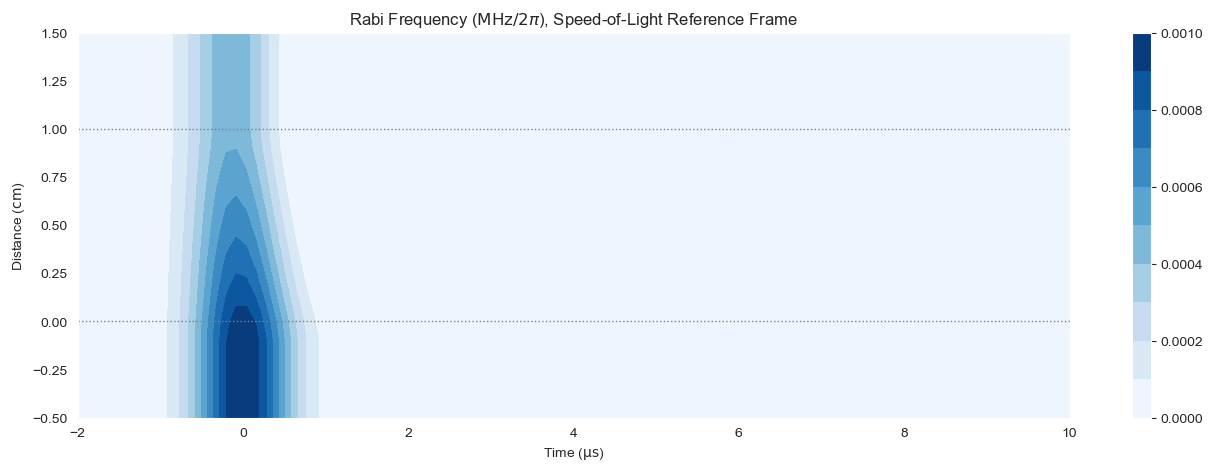

In [19]:
fig, ax = plt.subplots(figsize=(16, 5))
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mbs.tlist, mbs.zlist, 
                 np.abs(mbs.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\mathrm{MHz} / 2\pi $), Speed-of-Light Reference Frame')
ax.set_xlabel('Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Distance ($\mathrm{cm}$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

We see that the ringing in the system has been damped. In other solvers, decay is neglected and the Schrödinger equation is solved rather than the Lindblad master equation. In real atomic systems, unless the times we're looking at are very short compared to the decay lifetime, inhomogeneous broadening by spontaneous decay has considerable effect and is important to include in a model.

## Using a Natural Unit System

It is possible to use any reciprocal angular momentum and time units (e.g. $2\pi \mathrm{~ MHz}$ and $\mathrm{~ \mu s}$ in the above example). The length unit is also arbitrary (e.g. $\mathrm{cm}$) as long as the interaction strength $Ng$ is given in the same units (e.g. $\mathrm{2\pi~MHz~/cm}$).

For a two-level system we have a single natural linewidth, and so it is convenient to introduce a natural unit system, with frequencies in units of the natural linewidth $\Gamma$, times in units of the reciprocal spontaneous decay lifetime $\tau = 1/\Gamma$ and distances in units of the length of the medium $L$.

By introducing this natural unit system we are able to reduce the number of parameters involved in the mathematical problem. For example, it becomes clear that increasing the length of the medium ten times is equivalent to raising the number density by the same scale, or by choosing a system with a suitably higher dipole moment.

For most examples in this documentation from now on, we will use this natural unit system.

## Shifting to the Fixed Frame of Reference

We solve the problem in a frame of reference that moves with the speed of light across the medium. This means we can keep time in the system separate from distance, which makes the coupled equations easier to solve. We can also see all the important details of the solution in this frame of reference, as in the plots above. But if we want to look at how a field actually propagates in time, we need to shift back to a fixed (or laboratory) frame of reference. To do that we need to connect the time and space dimensions via the speed of light in the system. The utilities for this shift are in the `fixed` module.

In [20]:
from maxwellbloch import fixed

We define the speed of light based on the units in the system. For example, in the units above, $c \approx 3 \times 10^4 ~ \mathrm{cm / \mu s }$. If I put that speed in to the simulation results above, you will see no difference in the output. It will be too fast, and appear that the pulse progresses through the medium instantanously. Instead we can put in a slow speed-of-light to get an idea of what the shift does, say $10^{-5} c$. Something like looking at the pulse in slow motion.

In [21]:
speed_of_light = 0.3 # [cm /μs] THIS IS 10^5 SLOWER THAN C!

tlist_fixed_frame = fixed.t_list(mbs, speed_of_light)
field_fixed_frame = fixed.rabi_freq_abs(mbs, 0, speed_of_light)

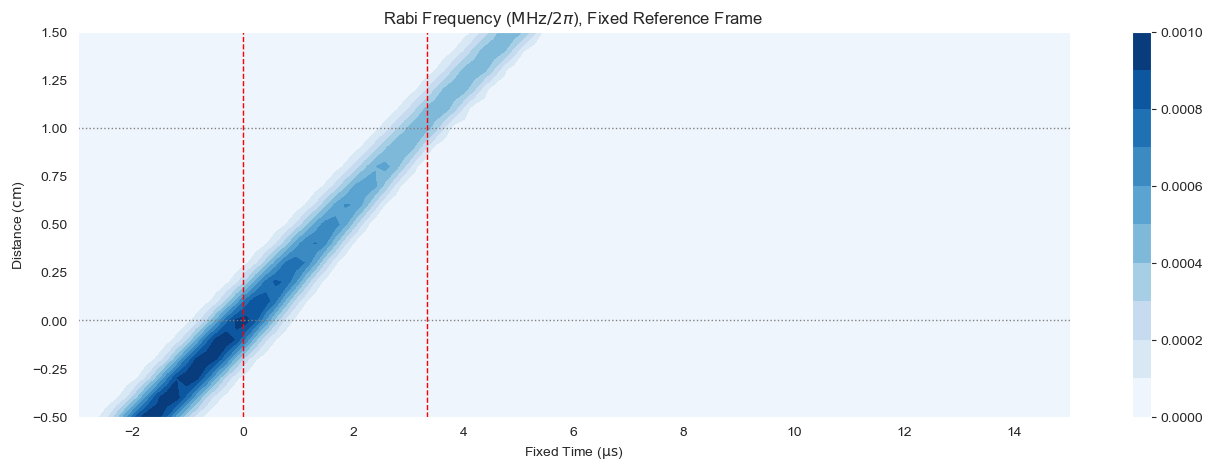

In [22]:
fig, ax = plt.subplots(figsize=(16, 5))
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(tlist_fixed_frame, mbs.zlist, 
                 np.abs(field_fixed_frame/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\mathrm{MHz} / 2\pi $), Fixed Reference Frame')
ax.set_xlabel('Fixed Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Distance ($\mathrm{cm}$)')
for x in [0.0, 1/speed_of_light]:
    ax.axvline(x, c='red', lw=1.0, ls='dashed')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

So we see that in this simulation with a slow speed-of-light, the pulse would arrive at the back of the medium around $3.33 \mathrm{~ \mu s}$ after it hit the front of the medium. The shift to the fixed reference frame has the effect of skewing the results rightward as we move through the medium, representing progression through time as well as space.